# Projet Commande Entreprise - Projet 23 : Traitement d'Images Microscopiques par Intelligence Artificielle
## Partenariat avec Cobalt Contraception

### Contexte et Objectifs du Projet

Ce projet s'inscrit dans le cadre de l'UE Projet Commande Entreprise, semestre 7, formation ingénieur généraliste FISE IMT Atlantique. Il est réalisé en partenariat avec **Cobalt Contraception** (135 rue Claude Chappe, 29280, Plouzané), sous la supervision de **Mme Eléonore Abadie** (Présidente, contact@cobalt-contraception.com).

L'objectif final de notre partenaire est la mise au point d'un **dispositif de contraception masculine** naturel, réversible, et non-invasif. Pour favoriser l'acceptation de cette méthode, il est essentiel de permettre aux utilisateurs de réaliser facilement un **spermogramme à domicile**. Notre projet consiste à développer une solution de traitement d'image permettant de mesurer la concentration et la mobilité des spermatozoïdes via un système optique intégré dans un boîtier connecté à la caméra d'un smartphone.

### Description du Projet

Notre mission dans le cadre de ce projet est de concevoir un **premier prototype d'algorithme** capable de compter et analyser des cellules dans des images microscopiques. Cet algorithme sera optimisé pour fonctionner sur un environnement Linux embarqué, notamment sur une Raspberry Pi, et vise deux fonctionnalités principales :

1. **Détection et comptage des cellules** dans les images pour calculer leur concentration.
2. **Analyse de la mobilité cellulaire** dans des vidéos (futur développement).

### Livrables

- Algorithme de détermination de la concentration des cellules (60 %)
- Intégration de l’algorithme sur Raspberry Pi (30 %)
- Rapport d'analyse des différentes approches algorithmiques (10 %)

### Équipe Projet

- **Étudiants** : Khalil ABDELHEDI, Corentin BOUTAULT, Iyed DAMMAK (auteur du notebook), Thomas FAVRE, Skander MAHJOUB, Noah SCHOUAME, Fabien SENEQUIER
- **Conseiller** : Jack Bourdin White, qui nous a apporté son expertise et ses conseils précieux
- **Tuteur entreprise** : Mme Eléonore Abadie, Présidente, eleonore@cobalt-contraception.com
- **Tuteur académique** : Mme LANGLAIS Charlotte ,IMT Atlantique

### Mots-Clés
Computer vision, Image segmentation, Apprentissage profond, Raspberry Pi, Spermogramme à domicile

---



# CNN for counting 
This fil is for CNN application
This notebook presents a CNN-based approach developed for COBALT to automate sperm cell counting in microscopic images. The goal is to build a reliable model that can accurately detect and count cells, streamlining the fertility analysis process.

We’ll cover data preparation, model design, and evaluation to achieve an efficient and accurate cell-counting solution.

---

**Initialization and Importing Libraries and Tools** 

In [353]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [354]:
# Standard libraries
import sys
import os

# Adding a custom toolkit repository to the system path
# This allows for easy importing of custom tools from 'tool_kit' located in a parent directory
#path_to_tool_kit = os.path.abspath('/homes/i23damma/Bureau/Cobalt/cobalt')
path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)
    

# Import custom toolkit functions (e.g., utility functions or model-related functions)
import toolkit.tool_kit as tk
#sys.path.append('/homes/i23damma/Bureau/Cobalt/cobalt/CNN')
# Data manipulation and numerical operations
import numpy as np  # To install: `pip install numpy`
import pandas as pd  # To install: `pip install pandas`

# PyTorch library for image transformations
import torchvision.transforms as transforms  # To install: `pip install torchvision`

# Library for data visualization
import matplotlib.pyplot as plt  # To install: `pip install matplotlib`

# Importing PyTorch summary for model inspection
from torchsummary import summary  # To install: `pip install torchsummary`

# Core PyTorch libraries for deep learning
import torch  # To install: `pip install torch`
import torch.nn as nn
import torch.nn.functional as F

# Additional utility functions and tools
from torch.utils.data.sampler import SubsetRandomSampler
from costumize_data import CustomDataset  # Custom dataset handler

import seaborn as sns

**Loading and Displaying Dataset Information**

In [355]:
# Setting the path to the dataset using a function from the custom toolkit
# This allows the toolkit to locate and access the dataset files.
#tk.set_path_to_dataset('/homes/i23damma/Bureau/Cobalt/cobalt/')
tk.set_path_to_dataset('..')

# Loading the images and mask data using functions from the toolkit
images = tk.load_data_image()
mask = tk.load_data_mask()
# Displaying the first few entries of each DataFrame to understand the data structure
print(' images =\n', images)
print(' mask =\n', mask)
# 'mask' DataFrame:# - Type: pandas DataFrame# - Contains: Each entry has the image ID and the count of cells present in the image.
# 'images' DataFrame:# - Type: pandas DataFrame # - Contains: Each entry has the image ID, cell count, mask availability (boolean), and blur status.


 images =
                                    image_id  nb_cells mask  blur
0         SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1         SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2         SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3         SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4         SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
...                                     ...       ...  ...   ...
19195  SIMCEPImages_P24_C100_F48_s23_w2.TIF       100   no    48
19196  SIMCEPImages_P24_C100_F48_s24_w1.TIF       100   no    48
19197  SIMCEPImages_P24_C100_F48_s24_w2.TIF       100   no    48
19198  SIMCEPImages_P24_C100_F48_s25_w1.TIF       100   no    48
19199  SIMCEPImages_P24_C100_F48_s25_w2.TIF       100   no    48

[19200 rows x 4 columns]
 mask =
                                  image_id  nb_cells
0       SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1       SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2       SIMCEPImag

**Selecting and Filtering the Dataset**

In [356]:
mask_or_image = 'mask'  # Variable to determine which dataset to use

if mask_or_image == 'mask':
    df = mask  # If 'mask' is selected, assign the mask DataFrame to df
    # Filter the rows in the DataFrame where 'image_id' contains 'w1' (case insensitive)
    #df = df[df['image_id'].str.contains("w1", case=False, na=False)]
else:
    df = images.copy()  # If 'image' is selected, create a copy of the images DataFrame
    # Remove the 'blur' and 'mask' columns from the DataFrame
    #df.drop(columns=['blur', 'mask'], inplace=True) 
    # Uncomment the following line to filter images by 'w1' if needed
    # df = df[df['image_id'].str.contains("w1", case=False, na=False)]




df  # Display the resulting DataFrame


,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
1,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
3,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
...,...,...
1195,SIMCEPImages_A24_C100_F1_s23_w2.TIF,100
1196,SIMCEPImages_A24_C100_F1_s24_w1.TIF,100
1197,SIMCEPImages_A24_C100_F1_s24_w2.TIF,100
1198,SIMCEPImages_A24_C100_F1_s25_w1.TIF,100


**Data Normalization**

In [357]:
mean_label= df['nb_cells'].mean()
std_label = df['nb_cells'].std()

mean_label= 0
std_label = 1
# Centralisation et normalisation de la colonne 'label'
df['nb_cells'] = (df['nb_cells'] -mean_label) / std_label

Text(0, 0.5, 'Frequency')

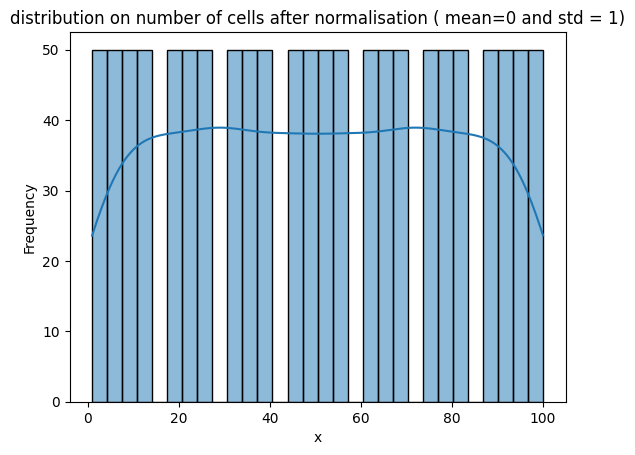

In [358]:


sns.histplot(df['nb_cells'], bins=30, kde=True)  # Plot a histogram with a kernel density estimate (KDE)
plt.title(f'distribution on number of cells after normalisation ( mean={mean_label} and std = {std_label})')  # Set the title of the plot
plt.xlabel('x')  # Label the x-axis
plt.ylabel('Frequency')  # Label the y-axis

**Splitting the Dataset into Training and Testing Sets**

In [359]:
# Set the fraction of data to be used for testing
frac = 0.2  # 20% of the data will be used for the test set
# Sample a subset of the DataFrame for testing without replacement
df_test = df.sample(frac=frac, replace=False, random_state=42)
# Create the training set by dropping the test set entries from the original DataFrame. Then shuffle the remaining data to create the training set
df_train = df.drop(df_test.index).sample(frac=1, random_state=42)

print('len(df) =', len(df))  # Total number of samples in the original DataFrame
print('len(df_train) =', len(df_train))  # Number of samples in the training set
print('len(df_test) =', len(df_test))  # Number of samples in the test set

print('df_train =\n', df_train.head())  # Show the first few rows of the training DataFrame
print('df_test =\n', df_test.head())  # Show the first few rows of the testing DataFrame


len(df) = 1200
len(df_train) = 960
len(df_test) = 240
df_train =
                                  image_id  nb_cells
1052   SIMCEPImages_A22_C91_F1_s02_w1.TIF      91.0
599    SIMCEPImages_A12_C48_F1_s25_w2.TIF      48.0
448    SIMCEPImages_A09_C35_F1_s25_w1.TIF      35.0
1121   SIMCEPImages_A23_C96_F1_s11_w2.TIF      96.0
1155  SIMCEPImages_A24_C100_F1_s03_w2.TIF     100.0
df_test =
                                  image_id  nb_cells
1178  SIMCEPImages_A24_C100_F1_s15_w1.TIF     100.0
865    SIMCEPImages_A18_C74_F1_s08_w2.TIF      74.0
101    SIMCEPImages_A03_C10_F1_s01_w2.TIF      10.0
439    SIMCEPImages_A09_C35_F1_s20_w2.TIF      35.0
58      SIMCEPImages_A02_C5_F1_s05_w1.TIF       5.0


**Displaying Dataset Dimensions**

In [360]:
# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")
# Print the length of the training DataFrame
print(f"Number of training samples: {len(df_train)}")

DataFrame shape: (1200, 2)
Number of training samples: 960


**Displaying Sample Images with Cell Count Annotations**

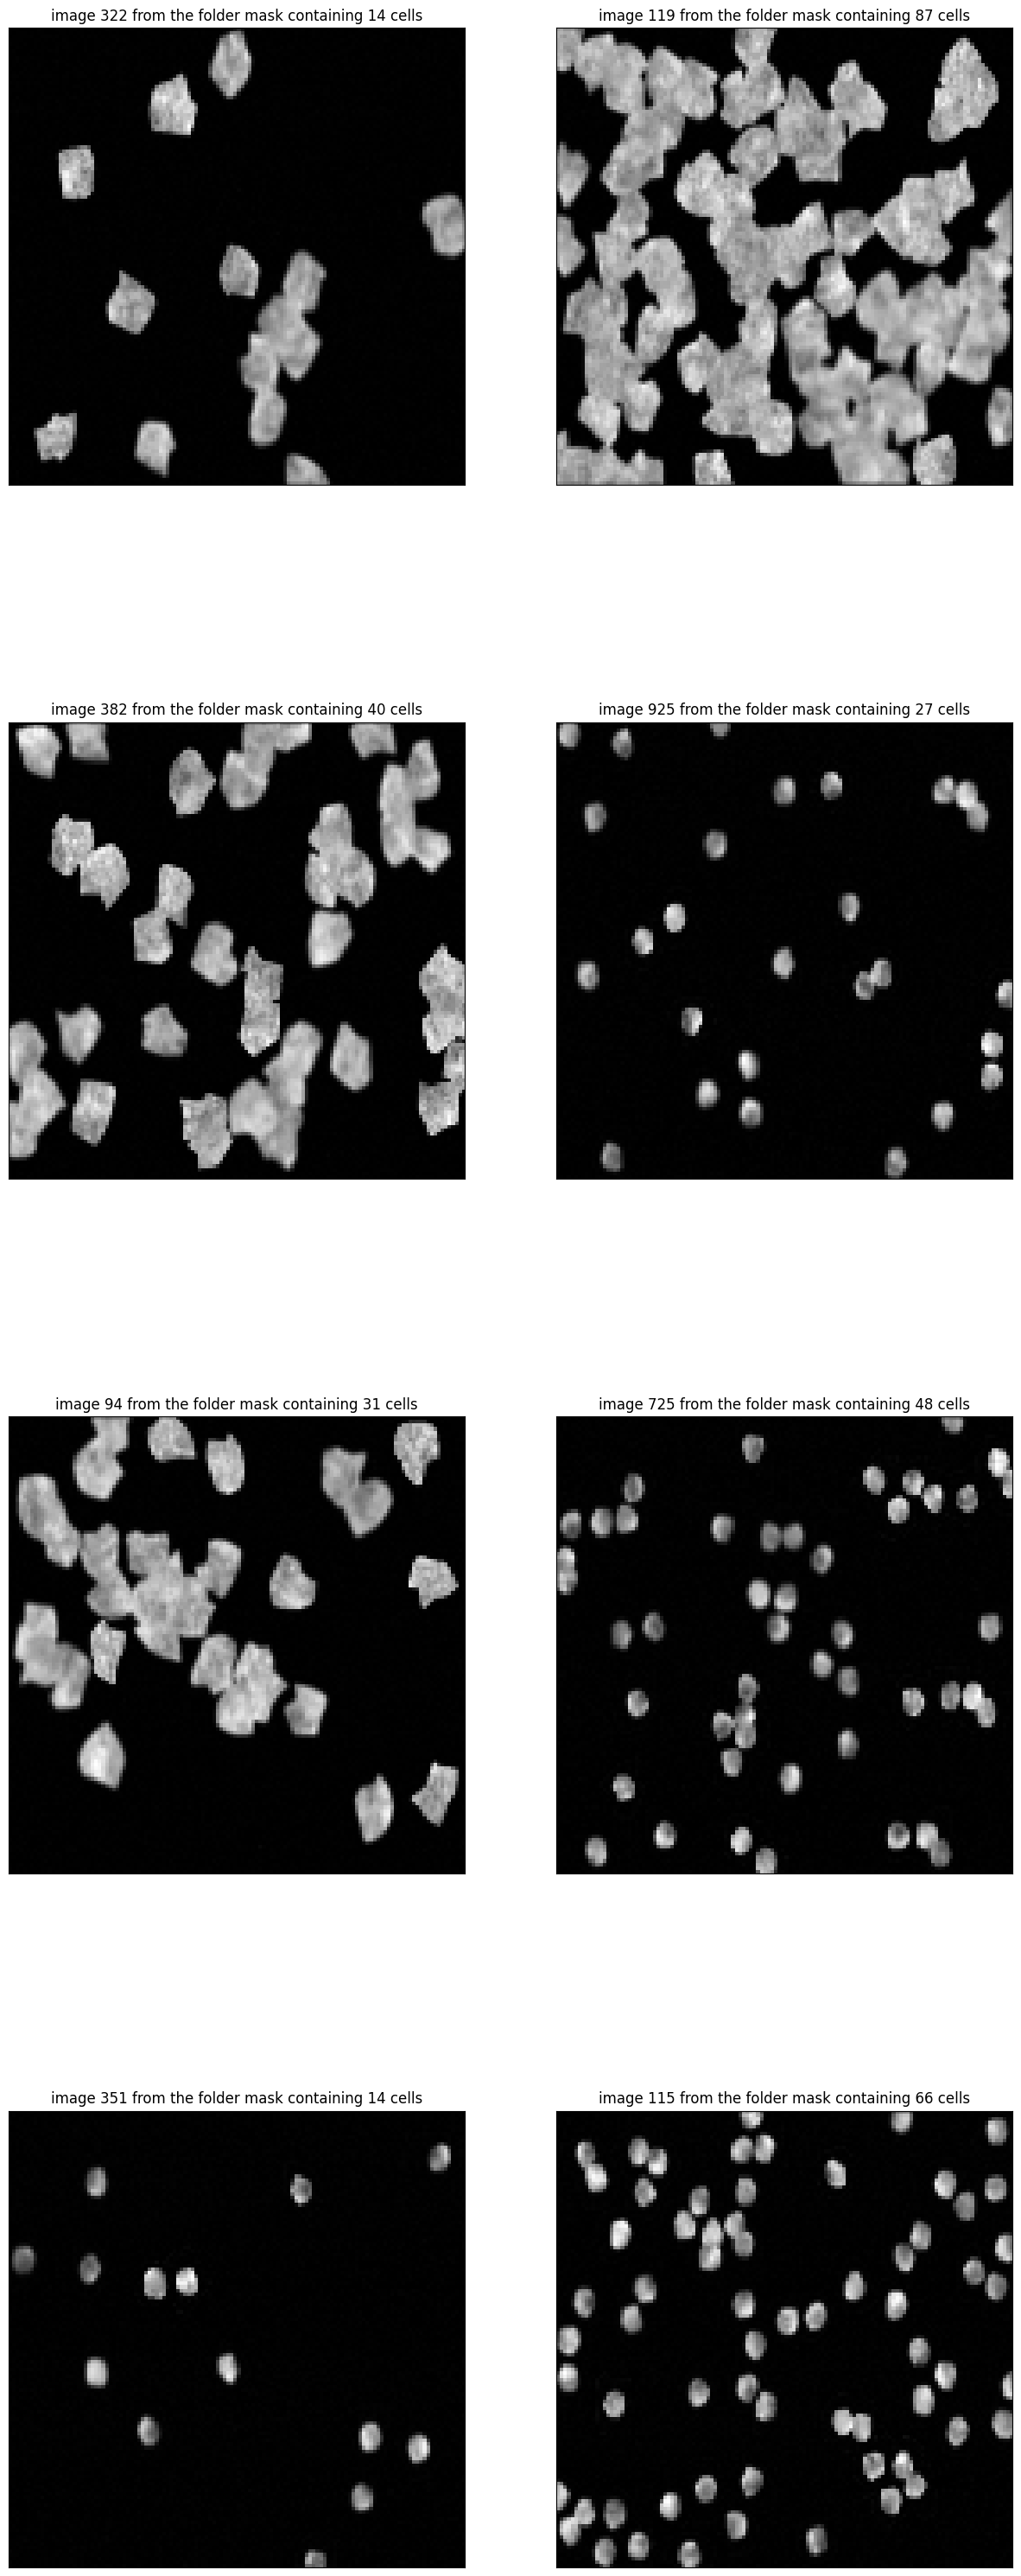

In [361]:
# Set the image height and width
IMG_HEIGHT = 128
IMG_WIDTH = 128
# Assign the training DataFrame to Matrix
Matrix = df_train
# Number of images to show
n_img_to_show = 8
# Create a figure with a specified size
fig = plt.figure(figsize=(15, 5*n_img_to_show ))
# Create a list of indices based on the length of the Matrix
indices = list(range(len(Matrix)))
# Shuffle the indices randomly
np.random.shuffle(indices)
# Loop through the number of images to show
for i in range(n_img_to_show):
    # Add a subplot to the figure
    ax = fig.add_subplot( n_img_to_show // 2,2, i + 1, xticks=[], yticks=[])
    # Get the image using the tk.get_image function and display it
    ax.imshow(np.squeeze(tk.get_image(
        img_id=Matrix['image_id'].iloc[indices[i]],
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        mask_or_image=mask_or_image
    )), cmap='gray')
    # Set the title of the subplot
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {int((Matrix["nb_cells"].iloc[indices[i]])*std_label+mean_label)} cells')
# Show the figure
plt.show()

**Data Loader Creation for Training, Validation, and Testing**

In [362]:
# Define batch size and validation size
batch_size = 32  # Number of samples per batch to load  # mettre en puissance de 2 #plus batch size est grand plus learn rate est peut etre elevée 
valid_size = 0.25  # Percentage of training set to use as validation

# Function to create data loaders for training, validation, and testing
def create_data_loaders(batch_size, valid_size, train_data, test_data):
  # Create a data loader for the test dataset
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  # Generate a list of indices for the training data and shuffle them
  indices = list(range(len(train_data)))
  np.random.shuffle(indices)
  # Calculate the split index for validation data
  split = int(np.floor(valid_size * len(train_data)))
  # Split the indices into training and validation indices
  train_indexes, valid_indexes = indices[split:], indices[:split]
  # Create samplers for validation and training data
  valid_samplers = SubsetRandomSampler(valid_indexes)
  train_samplers = SubsetRandomSampler(train_indexes)
  # Create data loaders for validation and training data using the samplers
  valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_samplers)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_samplers)
  # Return the data loaders
  return train_loader, valid_loader, test_loader




**Image Transformation and DataLoader Setup**

In [363]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH))  # Resize the image to the desired dimensions
])
# Create the training dataset using the custom dataset class and the defined transformation
train_data = CustomDataset(df_train, transform=transform)
train_data.set_path_to_dataset('..')  # Set the path to the dataset for the training data
# Create the testing dataset using the custom dataset class and the defined transformation
test_data = CustomDataset(df_test, transform=transform)
test_data.set_path_to_dataset('..')  # Set the path to the dataset for the testing data
# Create data loaders for training, validation, and testing datasets
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

In [364]:
print(train_data.__getitem__(100)[0])
torch.max(train_data.__getitem__(100)[0])

tensor([[[0.0021, 0.0041, 0.0025,  ..., 0.0035, 0.0031, 0.0050],
         [0.0025, 0.0030, 0.0026,  ..., 0.0036, 0.0040, 0.0033],
         [0.0032, 0.0033, 0.0034,  ..., 0.0023, 0.0026, 0.0052],
         ...,
         [0.0038, 0.0021, 0.0027,  ..., 0.0027, 0.0036, 0.0034],
         [0.0014, 0.0023, 0.0032,  ..., 0.0023, 0.0033, 0.0042],
         [0.0027, 0.0031, 0.0048,  ..., 0.0022, 0.0023, 0.0040]]])


tensor(0.8411)

**Training Function for Neural Network**

In [365]:


def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):
  """
    Train and validate the model.

    Parameters:
    n_epochs (int): Number of epochs to train the model.
    train_loader (DataLoader): DataLoader for the training data.
    valid_loader (DataLoader): DataLoader for the validation data.
    model (nn.Module): The neural network model to train.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.

    Returns:
    train_losses (list): List of training losses for each epoch.
    valid_losses (list): List of validation losses for each epoch.
    """
  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          
          optimizer.zero_grad()
          output=model(data)
          #print('label=',label,'\n','output=',output)
          output= output.view(-1)
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.float32)

        with torch.no_grad():
          output=model( data)
          
        output= output.view(-1)
        loss=criterion(label,output)
        valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
      
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

**Evaluation Function for Neural Network**

In [366]:
def evaluation1(model, test_loader, criterion ):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(101))
  class_total = list(0. for i in range(101))
  #creat a empty dict of 101 elements
  dict={}
  
  for i in range(1,101):
      dict[i]=[]
    
  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.float32)
      
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      
      loss = criterion(output, label)

      test_loss += loss.item() #*data.size(0)
      
      pred = (output*std_label+mean_label) # convert output probabilities to predicted class
      
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          number_expected = int(label.data[i]*std_label+mean_label)
          
          class_correct[number_expected] += correct[i].item()
          class_total[number_expected] += 1
          
          
          
          dict[number_expected].append(int(pred[i]))
  
      
  
  #print and return the results
  for i in range(100):
     if class_total[i] > 0 : 
        print( 'For the true value ', i, 'the predicted values are ', dict[i],' \n and the mean value is = ', np.mean(dict[i]))
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(100):
      if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test accuracy of %1s: %2.2f%% (%2d/%2d)' % (str(i), accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
      #else: 
        #print('Test accuracy of %1s: N/A (0/0)' % str(i))

  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

**Resnet Class Overview**

In [367]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleResNet(nn.Module):
    def __init__(self, img_height=128, img_width=128, img_channels=1, num_classes=100):
        super(SimpleResNet, self).__init__()
        
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        # maxpooling
        self.adapt2= nn.Sequential(*[
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        ])
        self.adapt3= nn.Sequential(*[
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1)
        ])
        self.adapt4= nn.Sequential(*[
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1)
        ])
        # Calculate flattened size for fully connected layers
        self.flattened_size = self._calculate_flattened_size(img_height, img_width)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 512) #self.flattened_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.fc3 = nn.Linear(num_classes, 1)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(self._residual_block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(self._residual_block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _residual_block(self, in_channels, out_channels, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d( in_channels,out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
        
        
        if downsample:
            layers=[]
            layers.append(downsample)
            layers.extend([
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)])
            
        else: 
            layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)]
        
        return nn.Sequential(*layers)
    
    def _calculate_flattened_size(self, height, width):
        # Applying 4 downsampling layers in the network, each reducing size by roughly half
        for _ in range(4):
            height = (height + 1) // 2
            width = (width + 1) // 2
        return height * width * 512  # `512` is the output channels from the last residual layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.pool1(x)
        
        
        y=x
        x = self.layer1(x)
        
        x=x+y



        y=x
        
        x = self.layer2(x)
       
        y=self.adapt2(y)
        x=y+x
        
        x = self.layer3(x)
        y=self.adapt3(y)
        x=y+x
        x = self.layer4(x)
        y=self.adapt4(y)
        x=y+x
        #x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        
        x = x.view(x.size(0), -1)

       
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


**Device Setup for PyTorch**

In [368]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


**Initialisation et transfert du modèle CNN**

In [369]:
Resnet = SimpleResNet( img_height=128, img_width=128, img_channels=1, num_classes=100 )
Resnet.to(device=device)  

SimpleResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d

**Visualizing the First Image and Its Label in the Training Dataset**

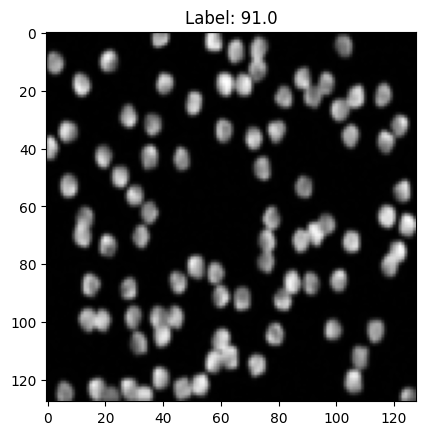

In [370]:
# Visualize the item
image, label = train_data.__getitem__(0)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
plt.title(f'Label: {label*std_label+mean_label}')
plt.show()

**Model Summary for Resnet**

In [371]:
#get the sumamry 
summary(Resnet, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,200
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         MaxPool2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2d-14          [-1, 128,

**Define Loss Function and Optimizer**

In [372]:
# Define the loss function as Mean Squared Error Loss
criterion = nn.MSELoss()

# Alternatively, you can use Smooth L1 Loss by uncommenting the following line
# criterion = nn.SmoothL1Loss()

# Define the optimizer as Adam with a learning rate of 0.001
optimizer = torch.optim.Adam(Resnet.parameters(), lr=0.001)

**Define Training Loop with Validation**

In [373]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 
image,label=next(iter(test_loader))
exemple=image[0].unsqueeze(0)
# Créer un exemple de tenseur d'entrée
dummy_input = exemple

In [374]:

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, name):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          output= output.view(-1)
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
              output= output.view(-1)
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), name)
          valid_loss_min = valid_loss

  return train_losses, valid_losses

**Training and Evaluation with Different Learning Rates Settings**

In [ ]:
n_epochs = [70] # number of epochs to train the model
lr_values=[ 0.001]
batch_sizes=[20 ]
results={}
for batch_size in batch_sizes: 
    print(f'the batch size is { batch_size}')
    for epoch in n_epochs: 
        for lr in lr_values:
            train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 
            print(f'For the dataset {mask_or_image}, start the experience for the learning rate {lr}, for n_epochs_{epoch}  :')
            name= f'resnet_lr_{lr}_n_epoch_{epoch}_batch_{batch_size}.pt'
            Resnet = SimpleResNet(img_height=128, img_width=128, img_channels=1, num_classes=100)
            Resnet.to(device=device) 
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(Resnet.parameters(), lr=lr)
            train_losses_k, valid_losses_k=training(epoch, train_loader, valid_loader, Resnet, criterion, optimizer, name )
            evaluation1( Resnet, test_loader, criterion)
            results[(lr,epoch,  mask_or_image)]= train_losses_k , valid_losses_k
            torch.onnx.export(
            Resnet,               # Le modèle chargé
            dummy_input,               # Exemple d'entrée
            name,            # Nom du fichier de sortie ONNX
            export_params=True,        # Exporter les paramètres du modèle
            opset_version=11,          # Version de l'opset ONNX
            do_constant_folding=True,  # Optimisations
            input_names=['input'],     # Nom de l'entrée
            output_names=['output'],   # Nom de la sortie
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Support de tailles dynamiques
            )

        


the batch size is 20
For the dataset mask, start the experience for the learning rate 0.001, for n_epochs_70  :
epoch: 1 	training Loss: 552.693343 	validation Loss: 1475.048793
validation loss decreased (inf --> 1475.048793).  Saving model ...


In [ ]:
n_epochs = [70] # number of epochs to train the model
lr_values=[ 0.001,0.01]
batch_sizes=[38 ]
results={}
for batch_size in batch_sizes: 
    print(f'the batch size is { batch_size}')
    for epoch in n_epochs: 
        for lr in lr_values:
            train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) 
            print(f'For the dataset {mask_or_image}, start the experience for the learning rate {lr}, for n_epochs_{epoch}  :')
            name= f'resnet_lr_{lr}_n_epoch_{epoch}_batch_{batch_size}.pt'
            Resnet = SimpleResNet(img_height=128, img_width=128, img_channels=1, num_classes=100)
            Resnet.to(device=device) 
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(Resnet.parameters(), lr=lr)
            train_losses_k, valid_losses_k=training(epoch, train_loader, valid_loader, Resnet, criterion, optimizer, name )
            evaluation1( Resnet, test_loader, criterion)
            results[(lr,epoch,  mask_or_image)]= train_losses_k , valid_losses_k
            torch.onnx.export(
            Resnet,               # Le modèle chargé
            dummy_input,               # Exemple d'entrée
            name,            # Nom du fichier de sortie ONNX
            export_params=True,        # Exporter les paramètres du modèle
            opset_version=11,          # Version de l'opset ONNX
            do_constant_folding=True,  # Optimisations
            input_names=['input'],     # Nom de l'entrée
            output_names=['output'],   # Nom de la sortie
            dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Support de tailles dynamiques
            )

        


**Plotting Training and Validation Loss over Epochs**

Text(0, 0.5, 'loss value')

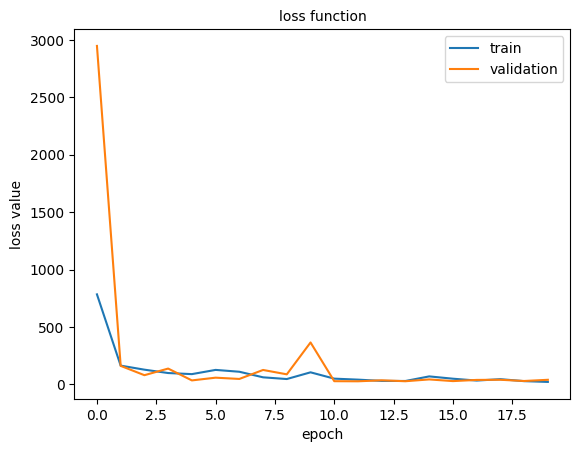

In [244]:
plt.plot( train_losses_k)
plt.plot( valid_losses_k)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)